## ETL (Extratct Transform and Load)

Ya tengo un contexto de los tres datasets, tambien una vision clara de los requerimientos (endpoints) que debe entregar mi sistema de recomendacion, ahora debo limpiar a profundidad los datos para tener lo estrictamente necesario en el momento de desplegar mi aplicacion, en la primera clase de consulta nos comentaron la importancia de la OPTIMIZACION.

In [1]:
import numpy as np
import pandas as pd
import json
import ast
import warnings
warnings.filterwarnings('ignore')  # Configuro el filtro para ignorar todas las advertencias.
pd.options.display.max_columns = None # Opcion para mostrar todas las columnas de un dataframe
from tools import countNulls
from tools import countDuplicates

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


En el EDA identifique que el archivo JSON australian_user_reviews y australian_users_items son los archivos  mas pesados, razon por la que decidi abordarlos primero, ademas del peso tienen demasiada informacion anidada y muchos datos por trabajar.

## Australian Users reviews

In [2]:
# Lectura del JSON
lista3 = []
with open("Data/australian_user_reviews.json", "r", encoding="utf-8") as file:
    for i in file:
        lista3.append(ast.literal_eval(i))

dataTemp3 = pd.DataFrame(lista3)

In [3]:
dfAusrw = pd.DataFrame(dataTemp3)

In [4]:
dfAusrw.info() # Doy un vistazo

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25799 entries, 0 to 25798
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   25799 non-null  object
 1   user_url  25799 non-null  object
 2   reviews   25799 non-null  object
dtypes: object(3)
memory usage: 604.8+ KB


In [5]:
dfAusrw["reviews"][0] # Columna a desanidar 

[{'funny': '',
  'posted': 'Posted November 5, 2011.',
  'last_edited': '',
  'item_id': '1250',
  'helpful': 'No ratings yet',
  'recommend': True,
  'review': 'Simple yet with great replayability. In my opinion does "zombie" hordes and team work better than left 4 dead plus has a global leveling system. Alot of down to earth "zombie" splattering fun for the whole family. Amazed this sort of FPS is so rare.'},
 {'funny': '',
  'posted': 'Posted July 15, 2011.',
  'last_edited': '',
  'item_id': '22200',
  'helpful': 'No ratings yet',
  'recommend': True,
  'review': "It's unique and worth a playthrough."},
 {'funny': '',
  'posted': 'Posted April 21, 2011.',
  'last_edited': '',
  'item_id': '43110',
  'helpful': 'No ratings yet',
  'recommend': True,
  'review': 'Great atmosphere. The gunplay can be a bit chunky at times but at the end of the day this game is definitely worth it and I hope they do a sequel...so buy the game so I get a sequel!'}]

Columna reviews

In [6]:
dfAusrw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25799 entries, 0 to 25798
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   25799 non-null  object
 1   user_url  25799 non-null  object
 2   reviews   25799 non-null  object
dtypes: object(3)
memory usage: 604.8+ KB


Necesito unir esta columna desanidada al df original y retirar la anidada ademas de desanidar la columna reviews

In [7]:
dfAusrw = dfAusrw.explode("reviews").reset_index()
dfAusrw = pd.concat([dfAusrw.drop(columns="reviews"), dfAusrw["reviews"].apply(pd.Series)],axis=1)

In [8]:
countNulls(dfAusrw) # Veo un porcentaje muy minimo

,Columna,Número de Nulos,Porcentaje de Nulos
index,index,0,0.0%
user_id,user_id,0,0.0%
user_url,user_url,0,0.0%
funny,funny,28,0.05%
posted,posted,28,0.05%
last_edited,last_edited,28,0.05%
item_id,item_id,28,0.05%
helpful,helpful,28,0.05%
recommend,recommend,28,0.05%
review,review,28,0.05%


Elimine las columnas innecesarias

In [9]:
dfAusrw = dfAusrw.drop(columns=["index", "funny", "user_url", "last_edited", "helpful", 0])

In [10]:
dfAusrw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59333 entries, 0 to 59332
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    59333 non-null  object
 1   posted     59305 non-null  object
 2   item_id    59305 non-null  object
 3   recommend  59305 non-null  object
 4   review     59305 non-null  object
dtypes: object(5)
memory usage: 2.3+ MB


Extraigo el año de la columna posted la cual hace referencia a la fecha de publicacion del cual necesito el año

In [11]:
# Extraje slide que necesite
dfAusrw["posted_year"] = dfAusrw["posted"].str.extract(r"(\d{4})")

In [12]:
dfAusrw["posted_year"][0]

'2011'

In [13]:
countNulls(dfAusrw)

,Columna,Número de Nulos,Porcentaje de Nulos
user_id,user_id,0,0.0%
posted,posted,28,0.05%
item_id,item_id,28,0.05%
recommend,recommend,28,0.05%
review,review,28,0.05%
posted_year,posted_year,10147,17.1%


Debo bajar el porcentaje del 17.1% de posted_year

In [14]:
medianPostedY = dfAusrw["posted_year"].median()

In [15]:
dfAusrw["posted_year"].fillna(medianPostedY, inplace=True)
dfAusrw["posted_year"] = dfAusrw["posted_year"].astype(int)

In [16]:
countNulls(dfAusrw)

,Columna,Número de Nulos,Porcentaje de Nulos
user_id,user_id,0,0.0%
posted,posted,28,0.05%
item_id,item_id,28,0.05%
recommend,recommend,28,0.05%
review,review,28,0.05%
posted_year,posted_year,0,0.0%


In [17]:
dfAusrw = dfAusrw.dropna(subset=["item_id"]) # Limpie item_id

In [18]:
dfAusrw = dfAusrw.drop(columns=["posted"]) # Elimine posted despues de extraer el año 

In [19]:
dfAusrw["item_id"] = dfAusrw["item_id"].astype(int)

Me es necesario leer output_steam_games.json para poder traer las columnas que pueda necesitar

In [20]:
lista = []  # cree una lista vacía para almacenar los datos

# abri el archivo JSON en modo de lectura ("r") con codificación utf-8
with open("Data/output_steam_games.json", "r", encoding="utf-8") as file:
    # Para leer  el contenido completo del archivo y se lo cargue como una lista de objetos JSON
    lista = [json.loads(line) for line in file.readlines()]


#Creo un data frame temporal
dataTemp = pd.DataFrame(lista)

In [21]:
dfOutputSteamGames = pd.DataFrame(dataTemp) # Creo copia de inicio rapido

En la fila del notebook # 97 Realizo la limpieza de dfOutputSteamGames y este es el resultado 

In [22]:
dfOutputSteamGames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120445 entries, 0 to 120444
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   publisher     24083 non-null  object
 1   genres        28852 non-null  object
 2   app_name      32133 non-null  object
 3   title         30085 non-null  object
 4   url           32135 non-null  object
 5   release_date  30068 non-null  object
 6   tags          31972 non-null  object
 7   reviews_url   32133 non-null  object
 8   specs         31465 non-null  object
 9   price         30758 non-null  object
 10  early_access  32135 non-null  object
 11  id            32133 non-null  object
 12  developer     28836 non-null  object
dtypes: object(13)
memory usage: 11.9+ MB


In [50]:
dfOutputSteamGames = dfOutputSteamGames.dropna(subset=['id'])

In [51]:
dfOutputSteamGames['id'] = dfOutputSteamGames['id'].astype('int32') # Para que me permita realizar el merge 

In [52]:
dfAusrw = pd.merge(dfAusrw, dfOutputSteamGames, left_on='item_id', right_on='id', how='left')

In [53]:
dfAusrw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59305 entries, 0 to 59304
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       59305 non-null  object 
 1   item_id       59305 non-null  int32  
 2   recommend     59305 non-null  object 
 3   review        59305 non-null  object 
 4   posted_year   59305 non-null  int32  
 5   genres        50450 non-null  object 
 6   title         50450 non-null  object 
 7   specs         50450 non-null  object 
 8   price         50450 non-null  float64
 9   early_access  50450 non-null  object 
 10  id            50450 non-null  float64
 11  developer     50450 non-null  object 
 12  release_year  50450 non-null  object 
dtypes: float64(2), int32(2), object(9)
memory usage: 5.4+ MB


In [54]:
dfAusrw = dfAusrw.drop(columns=["genres", "specs", "price", "early_access", "id"]) # Me quedo con lo necesario

In [55]:
countNulls(dfAusrw)

,Columna,Número de Nulos,Porcentaje de Nulos
user_id,user_id,0,0.0%
item_id,item_id,0,0.0%
recommend,recommend,0,0.0%
review,review,0,0.0%
posted_year,posted_year,0,0.0%
title,title,8855,14.93%
developer,developer,8855,14.93%
release_year,release_year,8855,14.93%


Con la union de los dos dataframes quedan al rededor de un 15 % de los datos de las columnas tittle, developer, release_year estas nulos asi que se deben tratar por ser esa cantidad importante.

In [56]:
dfAusrw["title"].fillna("Withoutspec", inplace=True) # Impute
dfAusrw["developer"].fillna("Other", inplace=True)

## Analisis de sentimiento 

Como propuesta de trabajo como actividad de feature engineering debo crear la columna 'sentiment_analysis' aplicando análisis de sentimiento con NLP con la siguiente escala: debe tomar el valor '0' si es malo, '1' si es neutral y '2' si es positivo. Esta nueva columna debe reemplazar la de user_reviews.review para facilitar el trabajo de los modelos de machine learning y el análisis de datos. De no ser posible este análisis por estar ausente la reseña escrita, debe tomar el valor de 1.

Recibe un desarrollador y devuelve un resumen del análisis de sentimiento de los juegos de una desarrolladora específica.

Aca toma sentido haber traido la columna de title de OutputSteamGames y va a ser necesario la importacion de la libreria nltk con sus especificaciones de "vader_lexicon" y sus paquetes nltk.sentiment.vader import SentimentIntensityAnalyzer.

In [57]:
import nltk
nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [58]:
from tools import sentimentScore # Funcion traida de tools.py 

In [59]:
dfAusrw["review"] = dfAusrw["review"].astype(str) # A tipo string para el analisis

Ya pude crear la columna sentimentAnalysis y  realizar la asignacion de valores

In [60]:
dfAusrw["sentiment_analysis"] = dfAusrw["review"].apply(sentimentScore)

In [61]:
# Elimino  release_year la cual no tiene nada que aportar en este dataframe 
dfAusrw = dfAusrw.drop(columns=['release_year'])

In [62]:
dfAusrw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59305 entries, 0 to 59304
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             59305 non-null  object
 1   item_id             59305 non-null  int32 
 2   recommend           59305 non-null  object
 3   review              59305 non-null  object
 4   posted_year         59305 non-null  int32 
 5   title               59305 non-null  object
 6   developer           59305 non-null  object
 7   sentiment_analysis  59305 non-null  int64 
dtypes: int32(2), int64(1), object(5)
memory usage: 3.2+ MB


In [63]:
dfAusrw.to_parquet("Data/dfAustralianUserReviews")

## Australian User Items

In [64]:
# Leo el archivo json suministrado
lista2 = []
with open("Data/australian_users_items.json", "r", encoding="utf-8") as file:
    for i in file.readlines():
        lista2.append(ast.literal_eval(i))

dataTemp2= pd.DataFrame(lista2)

In [65]:
# Creo copia de inicio rapido
dfAuserItems = pd.DataFrame(dataTemp2)

In [66]:
dfAuserItems.info() # Doy primer vistazo de un dataframe aparentemente pequeño, es porque tiene toda la informacion anidada

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88310 entries, 0 to 88309
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      88310 non-null  object
 1   items_count  88310 non-null  int64 
 2   steam_id     88310 non-null  object
 3   user_url     88310 non-null  object
 4   items        88310 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.4+ MB


In [67]:
dfAuserItems = dfAuserItems.dropna(how="all") # Elimino nulos

Columna Items- contiene mucha data anidada en formato lista de diccionarios al igual que el EDA utilizo el metodo json_normalize sobre mi archivo json ya instanciado en lista2

In [68]:
dfAuserItems["items"][0]

[{'item_id': '10',
  'item_name': 'Counter-Strike',
  'playtime_forever': 6,
  'playtime_2weeks': 0},
 {'item_id': '20',
  'item_name': 'Team Fortress Classic',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '30',
  'item_name': 'Day of Defeat',
  'playtime_forever': 7,
  'playtime_2weeks': 0},
 {'item_id': '40',
  'item_name': 'Deathmatch Classic',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '50',
  'item_name': 'Half-Life: Opposing Force',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '60',
  'item_name': 'Ricochet',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '70',
  'item_name': 'Half-Life',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '130',
  'item_name': 'Half-Life: Blue Shift',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '300',
  'item_name': 'Day of Defeat: Source',
  'playtime_forever': 4733,
  'playtime_2weeks': 0},
 {'item_id': '240',
  'item_name': 'Counter-Strike: S

In [69]:
# Como en el EDA aplico el metodo normalize()
dfAuserItems = pd.json_normalize(lista2, record_path="items", meta=["steam_id", "items_count", "user_id", "user_url"])

In [70]:
dfAuserItems.drop(["user_url"], axis=1, inplace=True) # Elimine columna innecesaria

## Vuelvo a trabajar con el data frame  dfOutputSteamGames

In [71]:
dfOutputSteamGames.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28785 entries, 88310 to 120443
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   genres        28785 non-null  object 
 1   title         28785 non-null  object 
 2   specs         28785 non-null  object 
 3   price         28785 non-null  float64
 4   early_access  28785 non-null  object 
 5   id            28785 non-null  int32  
 6   developer     28785 non-null  object 
 7   release_year  28785 non-null  object 
dtypes: float64(1), int32(1), object(6)
memory usage: 1.9+ MB


In [72]:
dfAuserItems["item_id"] = dfAuserItems["item_id"].astype(int) # Cambio a tipo entero columnas de cada df para el merge 
dfOutputSteamGames["id"] = dfOutputSteamGames["id"].astype(int)


In [73]:
dfAuserItems = pd.merge(dfAuserItems, dfOutputSteamGames[["id", "genres", "price", "developer","release_year"]], how="left", left_on="item_id", right_on="id")

In [74]:
dfAuserItems

,item_id,item_name,playtime_forever,playtime_2weeks,steam_id,items_count,user_id,id,genres,price,developer,release_year
0,10,Counter-Strike,6,0,76561197970982479,277,76561197970982479,10.0,[Action],9.99,Valve,2000
1,20,Team Fortress Classic,0,0,76561197970982479,277,76561197970982479,20.0,[Action],4.99,Valve,1999
2,30,Day of Defeat,7,0,76561197970982479,277,76561197970982479,30.0,[Action],4.99,Valve,2003
3,40,Deathmatch Classic,0,0,76561197970982479,277,76561197970982479,40.0,[Action],4.99,Valve,2001
4,50,Half-Life: Opposing Force,0,0,76561197970982479,277,76561197970982479,50.0,[Action],4.99,Gearbox Software,1999
...,...,...,...,...,...,...,...,...,...,...,...,...
5153204,346330,BrainBread 2,0,0,76561198329548331,7,76561198329548331,346330.0,"[Action, Adventure, Free to Play, Indie, Early...",4.99,Reperio Studios,2016
5153205,373330,All Is Dust,0,0,76561198329548331,7,76561198329548331,NaN,NaN,NaN,NaN,NaN
5153206,388490,One Way To Die: Steam Edition,3,3,76561198329548331,7,76561198329548331,388490.0,"[Adventure, Free to Play]",4.99,CoaguCo Industries,2015
5153207,521570,You Have 10 Seconds 2,4,4,76561198329548331,7,76561198329548331,521570.0,"[Casual, Free to Play, Indie]",4.99,Tamationgames,2016


In [75]:
countNulls(dfAuserItems)

,Columna,Número de Nulos,Porcentaje de Nulos
item_id,item_id,0,0.0%
item_name,item_name,0,0.0%
playtime_forever,playtime_forever,0,0.0%
playtime_2weeks,playtime_2weeks,0,0.0%
steam_id,steam_id,0,0.0%
items_count,items_count,0,0.0%
user_id,user_id,0,0.0%
id,id,945406,18.35%
genres,genres,945406,18.35%
price,price,945406,18.35%


Las columnas pertenecientes a dfOutpuSteamGames tiene datos faltantes

In [76]:
# primero elimino id por tener los mismos datos que item_id
dfAuserItems.drop("id", axis=1, inplace=True)

Ahora reviso las otras columnas identificando que comparten los mismos nulos 

In [77]:
dfShow = dfAuserItems[dfAuserItems["genres"].isnull()].copy() 

In [78]:
dfAuserItems.dropna(subset=["genres"], inplace=True) #Elimino

Reviso como va quedando mi dataframe unificado 

In [79]:
dfAuserItems

,item_id,item_name,playtime_forever,playtime_2weeks,steam_id,items_count,user_id,genres,price,developer,release_year
0,10,Counter-Strike,6,0,76561197970982479,277,76561197970982479,[Action],9.99,Valve,2000
1,20,Team Fortress Classic,0,0,76561197970982479,277,76561197970982479,[Action],4.99,Valve,1999
2,30,Day of Defeat,7,0,76561197970982479,277,76561197970982479,[Action],4.99,Valve,2003
3,40,Deathmatch Classic,0,0,76561197970982479,277,76561197970982479,[Action],4.99,Valve,2001
4,50,Half-Life: Opposing Force,0,0,76561197970982479,277,76561197970982479,[Action],4.99,Gearbox Software,1999
...,...,...,...,...,...,...,...,...,...,...,...
5153202,304930,Unturned,677,677,76561198329548331,7,76561198329548331,"[Action, Adventure, Casual, Free to Play, Indie]",4.99,Smartly Dressed Games,2017
5153203,227940,Heroes & Generals,43,43,76561198329548331,7,76561198329548331,"[Action, Free to Play, Indie, Massively Multip...",4.99,Reto-Moto,2016
5153204,346330,BrainBread 2,0,0,76561198329548331,7,76561198329548331,"[Action, Adventure, Free to Play, Indie, Early...",4.99,Reperio Studios,2016
5153206,388490,One Way To Die: Steam Edition,3,3,76561198329548331,7,76561198329548331,"[Adventure, Free to Play]",4.99,CoaguCo Industries,2015


Es evidente la cantidad de ceros de playtime_forever

In [80]:
# Conte la cantidad de ceros 
countOPlayTime = (dfAuserItems['playtime_forever'] == 0).sum()
print(f"Número de registros con playtime_forever igual a 0: {countOPlayTime}")


Número de registros con playtime_forever igual a 0: 1404066


In [81]:
# Elimine registros con playtime_forever igual a 0
dfAuserItems = dfAuserItems[dfAuserItems['playtime_forever'] != 0]

In [82]:
dfAuserItems.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2803737 entries, 0 to 5153207
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   item_id           int32  
 1   item_name         object 
 2   playtime_forever  int64  
 3   playtime_2weeks   int64  
 4   steam_id          object 
 5   items_count       object 
 6   user_id           object 
 7   genres            object 
 8   price             float64
 9   developer         object 
 10  release_year      object 
dtypes: float64(1), int32(1), int64(2), object(7)
memory usage: 246.0+ MB


Despues de la segunda tutoria de proyecto nos aconsejaron realizar algunas pruebas de deploy y no me permitia realizar consultas por el tamaño del dataframe dfAuserItems asi que cree un nuevo data frame para seguir optmizando; estas columnas son las necesarias para los requerimientos de los dos primeros endpoints

In [83]:
dfEnds = dfAuserItems.loc[:, ["genres", "release_year","playtime_forever", "user_id"]].copy()
dfEnds

,genres,release_year,playtime_forever,user_id
0,[Action],2000,6,76561197970982479
2,[Action],2003,7,76561197970982479
8,[Action],2010,4733,76561197970982479
9,[Action],2004,1853,76561197970982479
10,[Action],2005,333,76561197970982479
...,...,...,...,...
5153024,"[Adventure, Casual, Free to Play, Indie, Simul...",2015,8,76561198323066619
5153202,"[Action, Adventure, Casual, Free to Play, Indie]",2017,677,76561198329548331
5153203,"[Action, Free to Play, Indie, Massively Multip...",2016,43,76561198329548331
5153206,"[Adventure, Free to Play]",2015,3,76561198329548331


In [84]:
dfEnds = dfEnds.explode("genres", ignore_index=False) # desanido generos

In [85]:
dfEnds

,genres,release_year,playtime_forever,user_id
0,Action,2000,6,76561197970982479
2,Action,2003,7,76561197970982479
8,Action,2010,4733,76561197970982479
9,Action,2004,1853,76561197970982479
10,Action,2005,333,76561197970982479
...,...,...,...,...
5153206,Adventure,2015,3,76561198329548331
5153206,Free to Play,2015,3,76561198329548331
5153207,Casual,2016,4,76561198329548331
5153207,Free to Play,2016,4,76561198329548331


Hasta el momento he tratado de optmizar los datos hasta el maximo, ahora es momento de encarar algunos endpoint

Recibe un género (str) y devuelve el año de lanzamiento con más horas jugadas

aca se que voy a necesitar dos columnas ['genres'] y ['release_year'] ahora necesito optmizar y vincular estas dos columnas para responder al requerimiento del primer end point.

Creo un archivo con los datos disponibles para el primer endpoint

In [86]:
from tools import yearGenPerHour

In [87]:
endOne = yearGenPerHour(dfEnds)

In [88]:
countNulls(endOne)

,Columna,Número de Nulos,Porcentaje de Nulos
géneros,géneros,0,0.0%
añoLanzamiento,añoLanzamiento,0,0.0%
tiempoJugado,tiempoJugado,0,0.0%


In [89]:
endOne

,géneros,añoLanzamiento,tiempoJugado
0,Action,2000,18661379
1,Action,2003,11969297
2,Action,2010,182666321
3,Action,2004,131222294
4,Action,2005,12426135
...,...,...,...
430,Hack and Slash,2016,3176
431,Twin Stick Shooter,2016,3176
432,Rogue-lite,2016,3176
433,Hidden Object,2009,1354


In [90]:
endOne['añoLanzamiento'] = endOne['añoLanzamiento'].astype(int)

In [91]:
endOne.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   géneros         435 non-null    object
 1   añoLanzamiento  435 non-null    int32 
 2   tiempoJugado    435 non-null    int64 
dtypes: int32(1), int64(1), object(1)
memory usage: 8.6+ KB


Creo parquet de acceso para consulta

In [92]:
endOne.to_parquet("Data/endpoint_one")

Segundo end point: 

Recibe un género y devuelve el usuario con más horas jugadas, junto al acumulado de horas por año.

Para cumplir esta consulta debo agrupar por usuario, genero y año con la sumatoria de ['playtime_forever'] 

In [93]:
from tools import hoursPerUserGenYear

In [94]:
endTwo = hoursPerUserGenYear(dfEnds)
endTwo

,user_id,genres,release_year,playtime
0,--000--,Action,2009,5329
1,--000--,Action,2010,22
2,--000--,Action,2011,6522
3,--000--,Action,2012,109346
4,--000--,Action,2013,363
...,...,...,...,...
2886316,zzzmidmiss,Sports,2010,194
2886317,zzzmidmiss,Sports,2014,16
2886318,zzzmidmiss,Strategy,2010,10
2886319,zzzmidmiss,Strategy,2011,69


Creo parquet de acceso para la consulta

In [95]:
'''endTwo.to_parquet("endpoint_two")''' 

'endTwo.to_parquet("endpoint_two")'

In [96]:
endTwo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2886321 entries, 0 to 2886320
Data columns (total 4 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   user_id       object
 1   genres        object
 2   release_year  object
 3   playtime      int64 
dtypes: int64(1), object(3)
memory usage: 88.1+ MB


In [97]:

dfAuserItems['release_year'] = dfAuserItems['release_year'].astype(str)

In [98]:
dfAuserItems.to_parquet('Data/dfAuserItems')

In [99]:
dfAuserItems.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2803737 entries, 0 to 5153207
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   item_id           int32  
 1   item_name         object 
 2   playtime_forever  int64  
 3   playtime_2weeks   int64  
 4   steam_id          object 
 5   items_count       object 
 6   user_id           object 
 7   genres            object 
 8   price             float64
 9   developer         object 
 10  release_year      object 
dtypes: float64(1), int32(1), int64(2), object(7)
memory usage: 246.0+ MB


## Output Steam Games

Continuando con output_steam_games.json

In [23]:
dfOutputSteamGames.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120445 entries, 0 to 120444
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   publisher     24083 non-null  object
 1   genres        28852 non-null  object
 2   app_name      32133 non-null  object
 3   title         30085 non-null  object
 4   url           32135 non-null  object
 5   release_date  30068 non-null  object
 6   tags          31972 non-null  object
 7   reviews_url   32133 non-null  object
 8   specs         31465 non-null  object
 9   price         30758 non-null  object
 10  early_access  32135 non-null  object
 11  id            32133 non-null  object
 12  developer     28836 non-null  object
dtypes: object(13)
memory usage: 11.9+ MB


In [24]:
dfOutputSteamGames = dfOutputSteamGames.dropna(how="all")

Me enfoco en optimizar mi coste computacional eiminando las columnas que no aportaran en nada en mis endpoints

In [25]:
dfOutputSteamGames.drop(["url", "reviews_url"], axis=1, inplace=True)

Extraigo el dato de mayor valor para mi modelo es decir el año de lanzamiento

In [26]:
dfOutputSteamGames["release_year"] = dfOutputSteamGames["release_date"].str.extract(r"(\d{4})")
dfOutputSteamGames.drop("release_date", axis=1, inplace=True) # Elimino columna innecesaria
dfOutputSteamGames["release_year"]

88310     2018
88311     2018
88312     2017
88313     2017
88314      NaN
          ... 
120440    2018
120441    2018
120442    2018
120443    2017
120444     NaN
Name: release_year, Length: 32135, dtype: object

In [27]:
releaseYearMed = dfOutputSteamGames["release_year"].median() # calculo media 
dfOutputSteamGames["release_year"].fillna(releaseYearMed, inplace=True) # Imputo con la media extraida
nullInRelease =  dfOutputSteamGames["release_year"].isnull().sum() # Reviso 
nullInRelease

0

Estandarizo la columna price

In [28]:
dfOutputSteamGames["price"] = pd.to_numeric(dfOutputSteamGames["price"], errors="coerce") # convierto a float

dfOutputSteamGames.loc[dfOutputSteamGames["price"].astype(str).str.contains("[fF]"), "price"] = 0.0 # Convierto F/free a 0


Aislo los NaN 

In [29]:
numericalValues = dfOutputSteamGames['price'][(dfOutputSteamGames['price'] != 'nan')]

En el EDA descubri otliers que pueden afectar mis metricas asi que trabajare con la media

In [30]:
medianPrice= dfOutputSteamGames["price"].median()
dfOutputSteamGames["price"].fillna(medianPrice, inplace=True)

Trabaje la columna -specs- la cual nos da especificaciones del tipo de juego si es descargable, un solo jugador o multijugador, observo valores nulos los cuales remplazare a -withoutspec-

In [31]:
dfOutputSteamGames['specs']

88310                                       [Single-player]
88311     [Single-player, Multi-player, Online Multi-Pla...
88312     [Single-player, Multi-player, Online Multi-Pla...
88313                                       [Single-player]
88314     [Single-player, Full controller support, HTC V...
                                ...                        
120440                  [Single-player, Steam Achievements]
120441    [Single-player, Steam Achievements, Steam Clou...
120442    [Single-player, Steam Achievements, Steam Trad...
120443     [Single-player, Steam Achievements, Steam Cloud]
120444    [Single-player, Stats, Steam Leaderboards, HTC...
Name: specs, Length: 32135, dtype: object

In [32]:
dfOutputSteamGames["specs"].fillna("withoutspec", inplace=True)

Tratamiento de la columna ID la cual tiene datos vitales y unicos para identificar cada juego 

In [33]:
inDuplicity = dfOutputSteamGames[dfOutputSteamGames.duplicated(subset="id", keep=False)]
inDuplicity

,publisher,genres,app_name,title,tags,specs,price,early_access,id,developer,release_year
88384,NaN,NaN,NaN,NaN,NaN,withoutspec,19.99,False,NaN,NaN,2016.0
102204,Bethesda Softworks,[Action],Wolfenstein II: The New Colossus,Wolfenstein II: The New Colossus,"[Action, FPS, Gore, Violent, Alternate History...","[Single-player, Steam Achievements, Full contr...",59.99,False,612880,Machine Games,2017
102883,Bethesda Softworks,[Action],Wolfenstein II: The New Colossus,Wolfenstein II: The New Colossus,"[Action, FPS, Gore, Violent, Alternate History...","[Single-player, Steam Achievements, Full contr...",59.99,False,612880,Machine Games,2017
119271,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,Batman: Arkham City - Game of the Year Edition,"[Action, Open World, Batman, Adventure, Stealt...","[Single-player, Steam Achievements, Steam Trad...",19.99,False,NaN,"Rocksteady Studios,Feral Interactive (Mac)",2012


In [34]:
dfOutputSteamGames.drop_duplicates(subset=['id'], inplace=True)

Hasta el momento e tratado las columnas con las cuales no noto similitud o emparentamiento con otras o que considero despues de un analisis minusioso no aportaran a mi sistema de recomendacion, ahora me enfocare en las columnas que veo tienen cierto o un alto grado de similitud.

En la mayoria de casos el mismo desarrollador es el mismo publicador , es conveniente eliminar una columna y no se vera afectado el desarrollo de mis endpoints

In [35]:
dfOutputSteamGames["publisher"] 

88310            Kotoshiro
88311     Making Fun, Inc.
88312         Poolians.com
88313                 彼岸领域
88314                  NaN
                ...       
120440     Ghost_RUS Games
120441              Sacada
120442        Laush Studio
120443            SIXNAILS
120444                 NaN
Name: publisher, Length: 32133, dtype: object

In [36]:
dfOutputSteamGames["developer"]

88310                    Kotoshiro
88311             Secret Level SRL
88312                 Poolians.com
88313                         彼岸领域
88314                          NaN
                    ...           
120440          Nikita "Ghost_RUS"
120441                      Sacada
120442    Laush Dmitriy Sergeevich
120443               xropi,stev3ns
120444                         NaN
Name: developer, Length: 32133, dtype: object

In [37]:
nullInPub = dfOutputSteamGames["publisher"].isnull().sum()
nullInDev= dfOutputSteamGames["developer"].isnull().sum()

nullInDev, nullInPub # Me quedo con la columna developer imputando valores de publisher -Unifico-

(3299, 8052)

In [38]:
dfOutputSteamGames["developer"].fillna(dfOutputSteamGames["publisher"], inplace=True)
dfOutputSteamGames.dropna(subset=["developer"], inplace=True) # Elimino registros vacios de developer
dfOutputSteamGames.drop("publisher", axis=1, inplace=True) # Elimino la columna publisher

Continue emparejando por similitud 

In [39]:
dfOutputSteamGames["genres"]

88310         [Action, Casual, Indie, Simulation, Strategy]
88311                  [Free to Play, Indie, RPG, Strategy]
88312     [Casual, Free to Play, Indie, Simulation, Sports]
88313                           [Action, Adventure, Casual]
88315                       [Action, Adventure, Simulation]
                                ...                        
120439                   [Action, Adventure, Casual, Indie]
120440                [Casual, Indie, Simulation, Strategy]
120441                            [Casual, Indie, Strategy]
120442                          [Indie, Racing, Simulation]
120443                                      [Casual, Indie]
Name: genres, Length: 28899, dtype: object

In [40]:
# Obtenemos la cantidad de nulos en "genres"
nullIngen= dfOutputSteamGames["genres"].isnull().sum()
nullIngen

166

In [41]:
dfOutputSteamGames["tags"]

88310         [Strategy, Action, Indie, Casual, Simulation]
88311     [Free to Play, Strategy, Indie, RPG, Card Game...
88312     [Free to Play, Simulation, Sports, Casual, Ind...
88313                           [Action, Adventure, Casual]
88315     [Action, Adventure, Simulation, FPS, Shooter, ...
                                ...                        
120439          [Action, Indie, Casual, Violent, Adventure]
120440                [Strategy, Indie, Casual, Simulation]
120441                            [Strategy, Indie, Casual]
120442                          [Indie, Simulation, Racing]
120443    [Indie, Casual, Puzzle, Singleplayer, Atmosphe...
Name: tags, Length: 28899, dtype: object

In [42]:
dfOutputSteamGames["genres"].fillna(dfOutputSteamGames["tags"], inplace=True) # Complete gneres con tags por relacion de etiqueta/contenido

In [43]:
dfOutputSteamGames.drop("tags", axis=1, inplace=True) # Elimino tags
dfOutputSteamGames.dropna(subset=["genres"], inplace=True) # limpio genres


Sigo trabajando las columnas por similitud de su contenido

In [44]:
dfOutputSteamGames["title"]

88310          Lost Summoner Kitty
88311                    Ironbound
88312      Real Pool 3D - Poolians
88313                      弹炸人2222
88315        Battle Royale Trainer
                    ...           
120439                Kebab it Up!
120440              Colony On Mars
120441    LOGistICAL: South Africa
120442               Russian Roads
120443         EXIT 2 - Directions
Name: title, Length: 28785, dtype: object

In [45]:
dfOutputSteamGames["app_name"]

88310          Lost Summoner Kitty
88311                    Ironbound
88312      Real Pool 3D - Poolians
88313                      弹炸人2222
88315        Battle Royale Trainer
                    ...           
120439                Kebab it Up!
120440              Colony On Mars
120441    LOGistICAL: South Africa
120442               Russian Roads
120443         EXIT 2 - Directions
Name: app_name, Length: 28785, dtype: object

En esta linea muestra el nivel de similitud entre las columnas

In [46]:
totRow = len(dfOutputSteamGames)
matching= (dfOutputSteamGames["app_name"] == dfOutputSteamGames["title"]).sum()

matchPercen = (matching / totRow) * 100
print(f"Match percentage: {matchPercen:.2f}%")

Match percentage: 98.11%


In [47]:
# Visualizamos la cantidad de nulos en cada columna
nulApp = dfOutputSteamGames["app_name"].isnull().sum()
nulTit= dfOutputSteamGames["title"].isnull().sum()

print(nulApp, nulTit)

0 0


In [48]:
dfOutputSteamGames.drop("app_name", axis=1, inplace=True) # Me quedo con tittle que es mas intuitiva

In [49]:
dfOutputSteamGames.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28785 entries, 88310 to 120443
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   genres        28785 non-null  object 
 1   title         28785 non-null  object 
 2   specs         28785 non-null  object 
 3   price         28785 non-null  float64
 4   early_access  28785 non-null  object 
 5   id            28785 non-null  object 
 6   developer     28785 non-null  object 
 7   release_year  28785 non-null  object 
dtypes: float64(1), object(7)
memory usage: 2.0+ MB


## Realizo el before and After

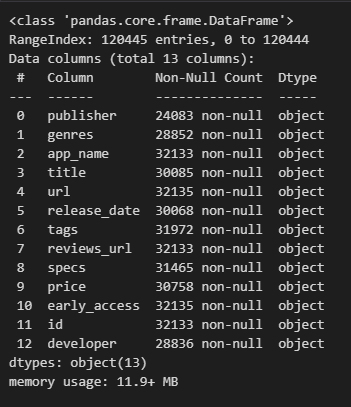 
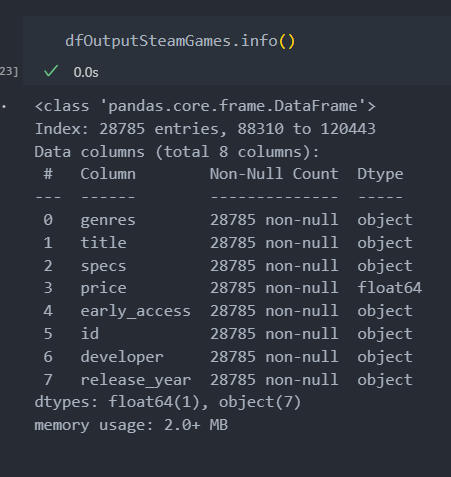


 ## Es evidente la optimizacion al pasar de 11.9 a 2.0 MB  

In [ ]:
'''dfOutputSteamGames.to_csv("Data/dfOutputSteamGames") use el formato csv por el tamaño de ser necesario lo convertire mas adelante a parquet''' 